<a href="https://colab.research.google.com/github/ashinshanly/ReverseDictionary-Using-CBOW-with-Attention-and-subword-information/blob/main/CBOW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Reshape, Flatten, LSTM, Dense, Dropout, Embedding, Bidirectional, GRU
from keras.optimizers import Adam
from keras import initializers, regularizers
from keras import optimizers
from keras.engine.topology import Layer
from keras import constraints
def dot_product(x, kernel):
	"""
	Wrapper for dot product operation, in order to be compatible with both
	Theano and Tensorflow
	Args:
		x (): input
		kernel (): weights
	Returns:
	"""
	if K.backend() == 'tensorflow':
		return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
	else:
		return K.dot(x, kernel)

class AttentionWithContext(keras.layers.Layer):
	"""
	Attention operation, with a context/query vector, for temporal data.
	Supports Masking.
	follows these equations:
	
	(1) u_t = tanh(W h_t + b)
	(2) \alpha_t = \frac{exp(u^T u)}{\sum_t(exp(u_t^T u))}, this is the attention weight
	(3) v_t = \alpha_t * h_t, v in time t
	# Input shape
		3D tensor with shape: `(samples, steps, features)`.
	# Output shape
		3D tensor with shape: `(samples, steps, features)`.
	"""

	def __init__(self,
				 W_regularizer=None, u_regularizer=None, b_regularizer=None,
				 W_constraint=None, u_constraint=None, b_constraint=None,
				 bias=True, **kwargs):

		self.supports_masking = True
		self.init = initializers.get('glorot_uniform')

		self.W_regularizer = regularizers.get(W_regularizer)
		self.u_regularizer = regularizers.get(u_regularizer)
		self.b_regularizer = regularizers.get(b_regularizer)

		self.W_constraint = constraints.get(W_constraint)
		self.u_constraint = constraints.get(u_constraint)
		self.b_constraint = constraints.get(b_constraint)

		self.bias = bias
		super(AttentionWithContext, self).__init__(**kwargs)

	def build(self, input_shape):
		assert len(input_shape) == 3

		self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
								 initializer=self.init,
								 name='{}_W'.format(self.name),
								 regularizer=self.W_regularizer,
								 constraint=self.W_constraint)
		if self.bias:
			self.b = self.add_weight(shape=(input_shape[-1]),
									 initializer='zero',
									 name='{}_b'.format(self.name),
									 regularizer=self.b_regularizer,
									 constraint=self.b_constraint)

		self.u = self.add_weight(shape = (input_shape[-1],),
								 initializer=self.init,
								 name='{}_u'.format(self.name),
								 regularizer=self.u_regularizer,
								 constraint=self.u_constraint)

		super(AttentionWithContext, self).build(input_shape)

	def compute_mask(self, input, input_mask=None):
		# do not pass the mask to the next layers
		return None

	def call(self, x, mask=None):
		uit = dot_product(x, self.W)

		if self.bias:
			uit += self.b

		uit = K.tanh(uit)
		ait = dot_product(uit, self.u)

		a = K.exp(ait)

		# apply mask after the exp. will be re-normalized next
		if mask is not None:
			# Cast the mask to floatX to avoid float64 upcasting in theano
			a *= K.cast(mask, K.floatx())

		# in some cases especially in the early stages of training the sum may be almost zero and this results in NaN's. 
		# Should add a small epsilon as the workaround
		# a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
		a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

		a = K.expand_dims(a)
		weighted_input = x * a
		
		return weighted_input

	def compute_output_shape(self, input_shape):
		return input_shape[0], input_shape[1], input_shape[2]
	
class Addition(Layer):
	"""
	This layer is supposed to add of all activation weight.
	We split this from AttentionWithContext to help us getting the activation weights
	follows this equation:
	(1) v = \sum_t(\alpha_t * h_t)
	
	# Input shape
		3D tensor with shape: `(samples, steps, features)`.
	# Output shape
		2D tensor with shape: `(samples, features)`.
	"""

	def __init__(self, **kwargs):
		super(Addition, self).__init__(**kwargs)

	def build(self, input_shape):
		self.output_dim = input_shape[-1]
		super(Addition, self).build(input_shape)

	def call(self, x):
		return K.sum(x, axis=1)

	def compute_output_shape(self, input_shape):
		return (input_shape[0], self.output_dim)

In [ ]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence
import numpy as np
from keras.preprocessing.text import Tokenizer

#data = open("/content/drive/MyDrive/ReverseDictionary/data/dataset_final.txt","r")
data = open("/content/drive/MyDrive/ReverseDictionary/data/dataset9.txt","r")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data)
word2id = tokenizer.word_index

# build vocabulary of unique words
word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
#with open('/content/drive/MyDrive/ReverseDictionary/data/dataset_final.txt', 'r') as data:
#    wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in data]
with open('/content/drive/MyDrive/ReverseDictionary/data/dataset9.txt', 'r') as data:
    wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in data]

#print(wids)
vocab_size = len(word2id)
embed_size = 100
window_size = 2 # context window size

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:100])

Vocabulary Size: 5799
Vocabulary Sample: [('something', 1), ('person', 2), ('especially', 3), ('used', 4), ('someone', 5), ('typically', 6), ('action', 7), ('particular', 8), ('people', 9), ('part', 10), ('place', 11), ('time', 12), ('thing', 13), ('state', 14), ('relating', 15), ('ones', 16), ('number', 17), ('body', 18), ('things', 19), ('make', 20), ('made', 21), ('process', 22), ('another', 23), ('large', 24), ('object', 25), ('surface', 26), ('area', 27), ('animal', 28), ('form', 29), ('fact', 30), ('order', 31), ('amount', 32), ('move', 33), ('small', 34), ('group', 35), ('piece', 36), ('material', 37), ('give', 38), ('event', 39), ('done', 40), ('activity', 41), ('position', 42), ('period', 43), ('without', 44), ('feeling', 45), ('great', 46), ('money', 47), ('point', 48), ('food', 49), ('physical', 50), ('cause', 51), ('together', 52), ('quality', 53), ('building', 54), ('substance', 55), ('public', 56), ('long', 57), ('degree', 58), ('human', 59), ('condition', 60), ('work', 6

In [ ]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    # print(corpus)
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)
            # context_words.append([words[1:]])
            # label_word.append(words[0])
            x = sequence.pad_sequences(context_words, maxlen = context_length)
            y = np_utils.to_categorical( label_word, vocab_size )
            yield (x, y)
            
# Test this out for some samples
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    print(x,y)
    # print(y)
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 2:
            break
        i += 1

[[  0   0 600 145]] [[0. 0. 0. ... 0. 0. 0.]]
[[   0 1816  145  261]] [[0. 0. 0. ... 0. 0. 0.]]
[[1816  600  261    5]] [[0. 0. 0. ... 0. 0. 0.]]
Context (X): ['abandon', 'cease', 'look', 'someone'] -> Target (Y): support
[[ 600  145    5 1817]] [[0. 0. 0. ... 0. 0. 0.]]
Context (X): ['cease', 'support', 'someone', 'desert'] -> Target (Y): look
[[   0  145  261 1817]] [[0. 0. 0. ... 0. 0. 0.]]
[[  0   0 261   5]] [[0. 0. 0. ... 0. 0. 0.]]
[[  0   0 601 129]] [[0. 0. 0. ... 0. 0. 0.]]
[[  0 114 129 121]] [[0. 0. 0. ... 0. 0. 0.]]
[[114 601 121   1]] [[0. 0. 0. ... 0. 0. 0.]]
Context (X): ['ability', 'possession', 'skill', 'something'] -> Target (Y): means


In [ ]:
def generate_context_word_pairs1(corpus, window_size, vocab_size):
    # print(corpus)
    context_length = window_size*2
    context_words = []
    label_word   = [] 
    for words in corpus:
        sentence_length = len(words)
        
        context_words = []
        label_word   = [] 
        context_words.append(words[1:])
        label_word.append(words[0])
        x = sequence.pad_sequences(context_words, maxlen=len(words)-1)
        y = np_utils.to_categorical(label_word, vocab_size)
        # print(x,y)
        yield (x, y)

i = 0
for x, y in generate_context_word_pairs1(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    # print(x,y)
    # print(y)
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Context (X): ['cease', 'support', 'look', 'someone', 'desert'] -> Target (Y): abandon
Context (X): ['possession', 'means', 'skill', 'something'] -> Target (Y): ability
Context (X): ['power', 'skill', 'means', 'opportunity', 'something'] -> Target (Y): able
Context (X): ['deliberate', 'termination', 'human', 'pregnancy', 'often', 'performed', 'first', 'weeks', 'pregnancy'] -> Target (Y): abortion
Context (X): ['subject', 'concerning'] -> Target (Y): about
Context (X): ['extended', 'space', 'touching'] -> Target (Y): above
Context (X): ['foreign', 'country', 'countries'] -> Target (Y): abroad
Context (X): ['state', 'away', 'place', 'person'] -> Target (Y): absence
Context (X): ['qualified', 'diminished', 'way', 'total'] -> Target (Y): absolute
Context (X): ['qualification', 'restriction', 'limitation', 'totally'] -> Target (Y): absolutely
Context (X): ['take', 'soak', 'energy', 'liquid', 'substance', 'chemical', 'physical', 'action'] -> Target (Y): absorb


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         579900    
_________________________________________________________________
attention_with_context (Atte (None, None, 100)         10200     
_________________________________________________________________
addition (Addition)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 5799)              585699    
Total params: 1,175,799
Trainable params: 1,175,799
Non-trainable params: 0
_________________________________________________________________
None


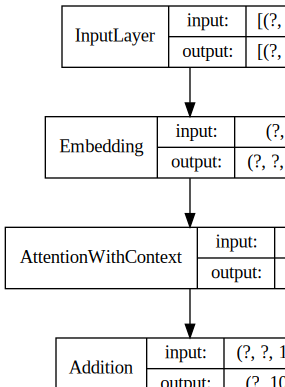

In [ ]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda
#from layers import AttentionWithContext,Addition

# build CBOW architecture
cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size))

cbow.add(AttentionWithContext())
# cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,0,0)))
cbow.add(Addition())
cbow.add(Dense(vocab_size, activation='softmax'))
cbow.compile(loss='categorical_crossentropy', optimizer='adam')

# Line to load the model again
# cbow.load_weights("/content/drive/MyDrive/ReverseDictionary/models/weights-improvement-cbow.hdf5")
# view model summary
print(cbow.summary())

# visualize model structure
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(cbow, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

In [ ]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda
cbow1 = Sequential()
cbow1.add(Embedding(input_dim=vocab_size, output_dim=embed_size))

cbow1.add(AttentionWithContext())
# cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,0,0)))
cbow1.add(Addition())
cbow1.add(Dense(vocab_size, activation='softmax'))
cbow1.compile(loss='categorical_crossentropy', optimizer='adam')

# Line to load the model again
cbow1.load_weights("/content/drive/MyDrive/ReverseDictionary/models/weights-improvement-cbow.hdf5")
weights = cbow1.get_weights()[0]
weights = weights[1:]
print(weights.shape)

#pd.DataFrame(weights, index=list(id2word.values())[1:]).head()


(5798, 100)


In [ ]:
# for epoch in range(1, 10):
#     loss = 0.
#     i = 0
#     for x, y in generate_context_word_pairs1(corpus=wids, window_size=window_size, vocab_size=vocab_size):
#         i += 1
#         loss += cbow1.train_on_batch(x, y)
#         if i % 100000 == 0:
#             print('Processed {} (context, word) pairs'.format(i))
#     cbow1.save_weights("/content/drive/MyDrive/ReverseDictionary/models/weights-improvement-cbow.hdf5",overwrite=True,save_format=None,options= None)
#     print('Epoch:', epoch, '\tLoss:', loss)
#     print()


Epoch: 1 	Loss: 37.62212862759824

Epoch: 2 	Loss: 42.07611732387109

Epoch: 3 	Loss: 37.08370753236564

Epoch: 4 	Loss: 36.47604142263993

Epoch: 5 	Loss: 36.41550545354908

Epoch: 6 	Loss: 37.406807443795806

Epoch: 7 	Loss: 42.89909254739435

Epoch: 8 	Loss: 36.50969086641614

Epoch: 9 	Loss: 36.430974999089635



In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

# compute pairwise distance matrix
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

# view contextually similar words
similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:11]+1] 
                   for search_term in ['abandon', 'about', 'absolute', 'accept', 'accurate', 'acid', 'acknowledge','actress']}

similar_words

(5798, 5798)


{'abandon': ['disloyal',
  'embryo',
  'compelling',
  'salary',
  'eagerness',
  'nonexecutive',
  'bath',
  'relationships',
  'birds',
  'test'],
 'about': ['comedy',
  'she',
  'myth',
  'session',
  'regardless',
  'transform',
  'editor',
  'however',
  'far',
  'advise'],
 'absolute': ['utmost',
  'considerably',
  'benefit',
  'regulate',
  'each',
  'troop',
  'sorry',
  'reveal',
  'virtue',
  'frame'],
 'accept': ['measured',
  'iron',
  'white',
  'electrical',
  'wrong',
  'traditionally',
  'reflects',
  'sold',
  'spread',
  'rope'],
 'accurate': ['granular',
  'yellowish',
  'rocks',
  'beds',
  'beaches',
  'deserts',
  'offer',
  'seabed',
  'roughly',
  'distinguishing'],
 'acid': ['microscopy',
  'nucleic',
  'multiply',
  'molecule',
  'coat',
  'infective',
  'host',
  'toilet',
  'bath',
  'washbasin'],
 'acknowledge': ['intentionally',
  'disregard',
  'relationships',
  'release',
  'maintains',
  'entertains',
  'observance',
  'deriving',
  'nonexecutive',
  

In [ ]:
import numpy as np
def evaluate(ground_truth, prediction):
   accu_1 = 0.
   accu_10 = 0.
   accu_100 = 0.
   length = len(ground_truth)
   for i in range(length):
       if ground_truth[i] in prediction[i][:100]:
           accu_100 += 1
           if ground_truth[i] in prediction[i][:10]:
               accu_10 += 1
               if ground_truth[i] == prediction[i][0]:
                   accu_1 += 1
   return accu_1/length*100, accu_10/length*100, accu_100/length*100

def evaluate_test(ground_truth, prediction):
   # print(ground_truth)
   # print(prediction)
   accu_1 = 0.
   accu_10 = 0.
   accu_100 = 0.
   length = len(ground_truth)
   pred_rank = []
   for i in range(length):
       try:
           pred_rank.append(prediction[i].tolist().index(ground_truth[i]))
       except:
           pred_rank.append(1000)
       if ground_truth[i] in prediction[i][:100]:
           accu_100 += 1
           if ground_truth[i] in prediction[i][:10]:
               accu_10 += 1
               if ground_truth[i] == prediction[i][0]:
                   accu_1 += 1
   print(pred_rank)
   return accu_1/length*100, accu_10/length*100, accu_100/length*100, np.median(pred_rank), np.sqrt(np.var(pred_rank))


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

predictions = []
ground_truth = []
#test = open('/content/drive/MyDrive/ReverseDictionary/data/dataset_final.txt', 'r')
test = open('/content/drive/MyDrive/ReverseDictionary/data/dataset9.txt', 'r')
for i, line in enumerate(test):
    print(line)
    if(i==200):
      break
    else:
      print("Testing " + str(i) + "/100")
    line = line.strip('\n').split('  ')
    # if(line[0] not in idx2word):
    #   continue
    ground_truth.append(word2id[line[0]])
    # print(ground_truth)
    definition = list(set(line[1].split(' ')))        	
    stopwords = ['a','an','the','is','are','in','of','by','at']
    if(len(definition)>18):
      for x in stopwords:
        if x in definition:
          definition.remove(x)
    idxs = []
    for word in definition:
        if(word==""):
          continue
        idxs.append(word2id[word])
    idxs = np.array([0] + idxs + [1]).reshape((1,len(idxs) + 2))
    #idxs = np.pad(np.array([0] + idxs + [1]), (0,l), 'constant', constant_values=(0))
    #idxs = idxs.reshape((1,20)) 
    prediction = cbow1.predict(idxs, verbose=0)
    ind=np.argpartition(prediction[0],-100)[-100:]
    predictions.append(ind)
    # print(predictions)

A_1,A_10,A_100,med,sq = evaluate_test(ground_truth,predictions)
print("Accuracy @ 1 = "+ str(A_1))
print("Accuracy @ 10 = "+ str(A_10))
print("Accuracy @ 100 = "+ str(A_100))
print("Median Prediction Rank = "+ str(med))
# print("Accuracy @ 1 = "+ A_1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
abandon   cease support look someone desert

Testing 0/100
ability   possession means skill something

Testing 1/100
able   power skill means opportunity something

Testing 2/100
abortion   deliberate termination human pregnancy often performed first weeks pregnancy

Testing 3/100
about   subject concerning

Testing 4/100
above   extended space touching

Testing 5/100
abroad   foreign country countries

Testing 6/100
absence   state away place person

Testing 7/100
absolute   qualified diminished way total

Testing 8/100
absolutely   qualification restriction limitation totally

Testing 9/100
absorb   take soak energy liquid substance chemical physical action

Testing 10/100
abuse   something effect purpose misuse

Testing 11/100
academic   relating education scholarship

Testing 12/100
accept   consent receive undertake something offered

Testing 13/100
access   means opportu

In [ ]:
!pip install flask-ngrok
from flask_ngrok import run_with_ngrok
from flask import Flask, request, jsonify, render_template, logging 
import webbrowser 

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
def create_app():
    app = Flask(__name__, template_folder='/content/drive/MyDrive/Colab Notebooks/templates', static_folder='/content/drive/MyDrive/Colab Notebooks/static')  
    return app
    
app = create_app()

#WEB-APP
@app.route('/', methods=['GET', 'POST'])
def index():
    meaning=[]
    if request.method == 'POST':
        words1 = request.form['definition'].split() 
        words2=[]
        for word in words1:
            if len(word)>=4 and word not in stopwords.words('english'):
                words2.append(word) 
        idxs = []
        for word in words2:
            idxs.append(word2id[word])

        idxs = np.array([0] + idxs + [1]).reshape((1,len(idxs) + 2))
        prediction = cbow1.predict(idxs, verbose=0)
        #print(prediction)
        ind=np.argpartition(prediction[0],-10)[-10:]
        #print(ind)
        for i in ind:
            meaning.append(id2word[i])
        return jsonify(meaning)
        #for idx in distance_matrix[word2id[words]-1].argsort()[1:6]+1:
        #    meaning.append(id2word[idx])
        #return jsonify(meaning)        
    else:
        #return "<h1>Running Flask on Google Colab!</h1>"
        return render_template('index.html')


run_with_ngrok(app) 
app.run()

        

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://880834cf630c.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [07/Dec/2020 04:22:49] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [07/Dec/2020 04:22:52] "GET /static/js/jquery-3.3.1.min.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Dec/2020 04:22:52] "GET /static/js/main.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Dec/2020 04:22:52] "GET /static/css/bulma/bulma.min.css HTTP/1.1" 200 -
127.0.0.1 - - [07/Dec/2020 04:22:55] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [07/Dec/2020 04:43:47] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [07/Dec/2020 04:43:50] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [07/Dec/2020 04:43:54] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [07/Dec/2020 05:58:05] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [07/Dec/2020 05:58:41] "POST / HTTP/1.1" 200 -


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
definition = input().lower()
#print(definition)
words1 = definition.split(' ')
words2=[]
for word in words1:
  if len(word)>=4 and word not in stopwords.words('english'):
    words2.append(word)
#words = definition.split(' ')
idxs = []
for word in words2:
    idxs.append(word2id[word])

idxs = np.array([0] + idxs + [1]).reshape((1,len(idxs) + 2))
prediction = cbow1.predict(idxs, verbose=0)
#print(prediction)
# index = np.argmax(prediction)
ind=np.argpartition(prediction[0],-10)[-10:]
#print(ind)
for i in ind:
  # meaning = idx2word[index]
  meaning = id2word[i]
  print(meaning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
similar to happiness
awareness
aware
depending
change
always
changing
depend
already
deeply
indoeuropean
